In [111]:
import time
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tweepy

from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.util import ngrams

In [112]:
sns.set()

## Setup tweepy api client

In [113]:
CONSUMER_KEY = ''
CONSUMER_SECRET = ''

ACCESS_TOKEN = ''
ACCESS_TOKEN_SECRET = ''

In [114]:
# Use tweepy to invoke Twitter API

# Set app and user access tokens
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# Create API client
api = tweepy.API(auth,wait_on_rate_limit=True)

In [115]:
def get_status_text(status):
    if hasattr(status, "retweeted_status"):  # Check if Retweet
        try:
            return status.retweeted_status.extended_tweet["full_text"]
        except AttributeError:
            return status.retweeted_status.text
    else:
        try:
            return status.extended_tweet["full_text"]
        except AttributeError:
            return status.text

In [116]:
# Define helper function for parsing Twitter API tweet responses

def parse_tweet(tweet):
    """
    Selects relevant fields from tweet status object
    https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object
    """
    return {
            'user_id': tweet.user.id,
            'user_screenname': tweet.user.screen_name,
            'text': get_status_text(tweet),
            'truncated': tweet.truncated,
            'created_at': tweet.created_at,
            'id_str': tweet.id_str,
            'in_reply_to_status_id_str': tweet.in_reply_to_status_id_str,
            'retweet_count': tweet.retweet_count,
            'favorite_count': tweet.favorite_count or 0,
            'media': tweet.entities.media if hasattr(tweet.entities, 'media') else [],
            'lang': tweet.lang if hasattr(tweet, 'lang') else 'und',
        }

## Request @MBTA user timeline
Returns up to 3200 most recent tweets on user timeline

In [117]:
username = 'mbta'
timeout = 999999
tweets = []

try: 
    for tweet in tweepy.Cursor(api.user_timeline,id=username,timeout=timeout).items(1000):
        tweets.append(parse_tweet(tweet))
except BaseException as e:
    print('failed on_status,',str(e))
    time.sleep(3)
except tweepy.RateLimitError:
    time.sleep(15 * 60)

print(f"Fetched {len(tweets)} tweets.")

Fetched 1000 tweets.


In [118]:
df_tweets = pd.DataFrame(tweets)
df_tweets

,user_id,user_screenname,text,truncated,created_at,id_str,in_reply_to_status_id_str,retweet_count,favorite_count,media,lang
0,150334831,MBTA,@bmahoneyMA Hello Brendan. Can you tell us if ...,False,2020-01-23 13:42:07,1220340939362795528,1220340276343996418,0,0,[],en
1,150334831,MBTA,@Kris_Hollie Good Morning Kristina and thanks ...,False,2020-01-23 13:40:12,1220340459245121536,1220336968959234048,0,0,[],en
2,150334831,MBTA,@tgoodwinma Good Morning Tom. We will pass thi...,False,2020-01-23 12:58:20,1220329920976560128,1220329510580768768,0,0,[],en
3,150334831,MBTA,@AdventurousNubi Thanks for this. We will pass...,False,2020-01-23 12:56:27,1220329445451538432,1220327754396315650,0,0,[],en
4,150334831,MBTA,@MyaB9782 Good Morning Stella. The delay getti...,False,2020-01-23 12:54:29,1220328950737653760,1220325579511209987,0,0,[],en
...,...,...,...,...,...,...,...,...,...,...,...
995,150334831,MBTA,@BaddingtonBearR @HaroldSipe @MBTA_CR Hello. I...,False,2019-12-18 21:42:14,1207415802930094085,1207415530614906881,0,0,[],en
996,150334831,MBTA,@Jackron312 Sorry about this. We have passed i...,False,2019-12-18 21:40:48,1207415440110211076,1207413032814555138,0,0,[],en
997,150334831,MBTA,@VykManda Thanks for the additional informatio...,False,2019-12-18 21:20:15,1207410267451265025,1207409323883806721,0,0,[],en
998,150334831,MBTA,Regularly scheduled service has resumed.\nhttp...,False,2019-12-18 21:17:47,1207409647386271751,None,1,2,[],en


In [119]:
# Set id_str as index

df_tweets.set_index('id_str', drop=True, inplace=True)
df_tweets

,user_id,user_screenname,text,truncated,created_at,in_reply_to_status_id_str,retweet_count,favorite_count,media,lang
id_str,,,,,,,,,,
1220340939362795528,150334831,MBTA,@bmahoneyMA Hello Brendan. Can you tell us if ...,False,2020-01-23 13:42:07,1220340276343996418,0,0,[],en
1220340459245121536,150334831,MBTA,@Kris_Hollie Good Morning Kristina and thanks ...,False,2020-01-23 13:40:12,1220336968959234048,0,0,[],en
1220329920976560128,150334831,MBTA,@tgoodwinma Good Morning Tom. We will pass thi...,False,2020-01-23 12:58:20,1220329510580768768,0,0,[],en
1220329445451538432,150334831,MBTA,@AdventurousNubi Thanks for this. We will pass...,False,2020-01-23 12:56:27,1220327754396315650,0,0,[],en
1220328950737653760,150334831,MBTA,@MyaB9782 Good Morning Stella. The delay getti...,False,2020-01-23 12:54:29,1220325579511209987,0,0,[],en
...,...,...,...,...,...,...,...,...,...,...
1207415802930094085,150334831,MBTA,@BaddingtonBearR @HaroldSipe @MBTA_CR Hello. I...,False,2019-12-18 21:42:14,1207415530614906881,0,0,[],en
1207415440110211076,150334831,MBTA,@Jackron312 Sorry about this. We have passed i...,False,2019-12-18 21:40:48,1207413032814555138,0,0,[],en
1207410267451265025,150334831,MBTA,@VykManda Thanks for the additional informatio...,False,2019-12-18 21:20:15,1207409323883806721,0,0,[],en


In [ ]:
# Save dataset locally
df_tweets.to_json('data/tweets.json')

## Request replies to:@MBTA 
Data restricted to 7 days old and represents a *sample* of true replies

In [120]:
replies=[]

count = 0
for tweet in tweepy.Cursor(api.search,q='to:'+username,result_type='recent',include_entities=True,timeout=timeout).items(5000):
    count += 1
    if (tweet.in_reply_to_status_id_str != None):
        reply = parse_tweet(tweet)
        replies.append(reply)

print(f"Fetched {count} tweets with {len(replies)} replies.")

Fetched 1363 tweets with 585 replies.


In [121]:
df_replies = pd.DataFrame(replies)
df_replies

,user_id,user_screenname,text,truncated,created_at,id_str,in_reply_to_status_id_str,retweet_count,favorite_count,media,lang
0,3419560522,Michael74720941,"@MBTA We already expect a 15 min delay, You sh...",False,2020-01-23 13:34:11,1220338944451268608,1220300643820326912,0,1,[],en
1,44511146,thismeliss,@MBTA not true. Porter platform packed and tra...,False,2020-01-23 13:23:41,1220336300005511168,1220316328604721152,0,0,[],en
2,25198114,abpontor,@MBTA @MyaB9782 I more surprised when there is...,False,2020-01-23 13:15:01,1220334118778671104,1220328950737653760,0,0,[],en
3,213150464,HeyItsJenay,@MBTA Bitch where? #dreadline #delayeveryday #...,False,2020-01-23 13:14:33,1220334002508378113,1220316328604721152,0,0,[],en
4,1155972315936632832,FwitterMonster,@MBTA Have you ever considered fixing the door...,False,2020-01-23 13:12:12,1220333408762695681,1220309177643536384,0,1,[],en
...,...,...,...,...,...,...,...,...,...,...,...
580,775139976895954945,TVFilmNerd,@MBTA This morning on the Braintree to Alewife...,True,2020-01-15 14:52:19,1217459502888505351,1217450028966600705,0,0,[],en
581,407174269,rosski7,@MBTA That’s a lie. Cmon be honest @FixTheMBTA...,False,2020-01-15 13:57:09,1217445618140045312,1217439170169376768,0,0,[],en
582,775139976895954945,TVFilmNerd,@MBTA On redline on the right side of the car ...,True,2020-01-15 13:55:45,1217445267794026496,1217443556790611974,0,0,[],en
583,359559091,paris1g,@MBTA Mechanical problems! 🤬🤬🤬🤬,False,2020-01-15 13:48:39,1217443481708158977,1217436548750303232,0,1,[],en


In [122]:
# Index replies by ids

df_replies.set_index('id_str', drop=True, inplace=True)
df_replies

,user_id,user_screenname,text,truncated,created_at,in_reply_to_status_id_str,retweet_count,favorite_count,media,lang
id_str,,,,,,,,,,
1220338944451268608,3419560522,Michael74720941,"@MBTA We already expect a 15 min delay, You sh...",False,2020-01-23 13:34:11,1220300643820326912,0,1,[],en
1220336300005511168,44511146,thismeliss,@MBTA not true. Porter platform packed and tra...,False,2020-01-23 13:23:41,1220316328604721152,0,0,[],en
1220334118778671104,25198114,abpontor,@MBTA @MyaB9782 I more surprised when there is...,False,2020-01-23 13:15:01,1220328950737653760,0,0,[],en
1220334002508378113,213150464,HeyItsJenay,@MBTA Bitch where? #dreadline #delayeveryday #...,False,2020-01-23 13:14:33,1220316328604721152,0,0,[],en
1220333408762695681,1155972315936632832,FwitterMonster,@MBTA Have you ever considered fixing the door...,False,2020-01-23 13:12:12,1220309177643536384,0,1,[],en
...,...,...,...,...,...,...,...,...,...,...
1217459502888505351,775139976895954945,TVFilmNerd,@MBTA This morning on the Braintree to Alewife...,True,2020-01-15 14:52:19,1217450028966600705,0,0,[],en
1217445618140045312,407174269,rosski7,@MBTA That’s a lie. Cmon be honest @FixTheMBTA...,False,2020-01-15 13:57:09,1217439170169376768,0,0,[],en
1217445267794026496,775139976895954945,TVFilmNerd,@MBTA On redline on the right side of the car ...,True,2020-01-15 13:55:45,1217443556790611974,0,0,[],en


In [ ]:
# save dataset locally
df_replies.to_json('data/replies.json')

In [126]:
df_replies_with_tweets = df_replies[['text', 'in_reply_to_status_id_str']].groupby('in_reply_to_status_id_str').agg(list)
df_replies_tweets = pd.concat([df_replies_with_tweets, df_tweets[['text']]], axis=1, join='inner')
df_replies_tweets.columns = ['replies', 'tweet']
df_replies_tweets

,replies,tweet
1214341706507866112,[@MBTA This just happened again with the 558 b...,@bosflyer93 Thanks for making us aware. We've ...
1214516247204974593,[@MBTA Two train sets running restricted and C...,New Orange Line Cars Update:\nOne of the new O...
1216842445465493506,[@MassGovernor @MBTA @bgcboston Free? How abo...,We're working to make CharlieCards more easily...
1217436548750303232,"[@MBTA Mechanical problems! 🤬🤬🤬🤬, @MBTA Does t...",#MBTA #RedLine Ashmont Branch: Delays of up to...
1217439170169376768,[@MBTA That’s a lie. Cmon be honest @FixTheMBT...,#MBTA #RedLine Ashmont Branch Update: Regularl...
...,...,...
1220300643820326912,"[@MBTA We already expect a 15 min delay, You s...",#MBTA #RedLine: Delays of up to 10 minutes nor...
1220309177643536384,[@MBTA Have you ever considered fixing the doo...,#MBTA #RedLine Update: Delays of up to 10 minu...
1220316328604721152,[@MBTA not true. Porter platform packed and tr...,#MBTA #RedLine Update: Regularly scheduled ser...
1220327241109975051,"[@MBTA Unfortunately I can't, I'm legally blin...",@AdventurousNubi Hello and thanks for reaching...


In [ ]:
# save dataset locally
df_replies_tweets.to_json('data/replies_tweets.json')

## EDA

In [127]:
df_replies_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 1214341706507866112 to 1220328950737653760
Data columns (total 2 columns):
replies    206 non-null object
tweet      206 non-null object
dtypes: object(2)
memory usage: 4.8+ KB


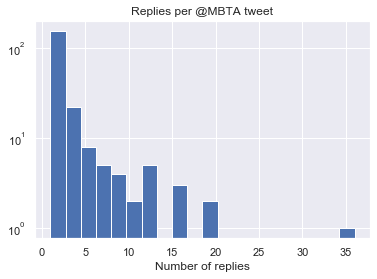

In [128]:
# Show distribution of number of replies per tweet

plt.hist(df_replies_tweets['replies'].str.len(), bins=20)
plt.xlabel('Number of replies')
plt.yscale('log') # ask Mukesh how sinful this is! :)
plt.title('Replies per @MBTA tweet')
plt.show()

In [129]:
# Combine tweet replies into document

documents = df_replies_tweets.replies.apply(lambda s: '-'.join(s))
documents

1214341706507866112    @MBTA This just happened again with the 558 bu...
1214516247204974593    @MBTA Two train sets running restricted and Ca...
1216842445465493506    @MassGovernor @MBTA @bgcboston Free?  How abou...
1217436548750303232    @MBTA Mechanical problems! 🤬🤬🤬🤬-@MBTA Does thi...
1217439170169376768    @MBTA That’s a lie. Cmon be honest @FixTheMBTA...
                                             ...                        
1220300643820326912    @MBTA We already expect a 15 min delay, You sh...
1220309177643536384    @MBTA Have you ever considered fixing the door...
1220316328604721152    @MBTA not true. Porter platform packed and tra...
1220327241109975051    @MBTA Unfortunately I can't, I'm legally blind...
1220328950737653760    @MBTA @MyaB9782 I more surprised when there is...
Name: replies, Length: 206, dtype: object

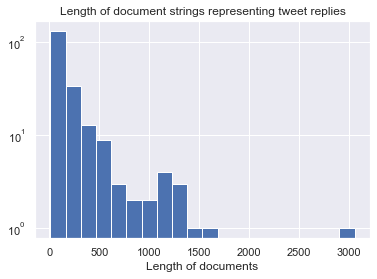

In [130]:
# Show distribution of document lengths

plt.hist(documents.str.len(), bins=20)
plt.xlabel('Length of documents')
plt.yscale('log')
plt.title('Length of document strings representing tweet replies')
plt.show()

## TF-IDF

In [131]:
# Define helper method to run TfidfVectorizer with n-gram option

def print_top_n_grams(docs, n=1):
    """Vectorize and print top 5 n-grams
    docs -- list of documents, in this case all replies to a tweet
    n -- n-gram to be passed to vectorizer
    """
    vectorizer = TfidfVectorizer(ngram_range=(n, n))
    vectors = vectorizer.fit_transform(docs)
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    df
    print(f"TOP {n}-grams: \n{df.sum().sort_values(ascending=False)[:5]}")

In [132]:
[print_top_n_grams(documents, i) for i in range(1,5)]

TOP 1-grams: 
mbta    22.866701
the     17.453948
you     12.101077
to      10.248523
co      10.153693
dtype: float64
TOP 2-grams: 
https co        7.973557
thank you       5.895966
mbta thank      3.511494
mbta mbta_cr    2.858223
mbta thanks     2.459981
dtype: float64
TOP 3-grams: 
mbta thank you        3.649280
mbta mbta_cr thank    2.121320
mbta_cr thank you     2.121320
the orange line       1.120034
you https co          1.115225
dtype: float64
TOP 4-grams: 
mbta mbta_cr thank you         3.0
mbta same time tomorrow        1.0
mbta park street station       1.0
mbta okay thank you            1.0
mbta gottalovemo very niice    1.0
dtype: float64


[None, None, None, None]

In [ ]:
# strip @-mentions?

## NMF (TODO)


In [ ]:
# csr matrix 

In [ ]:
# # Import NMF
# from sklearn.decomposition import NMF

# # Create an NMF instance: model
# model = NMF(n_components=6)

# # Fit the model to articles
# model.fit(articles)

# # Transform the articles: nmf_features
# nmf_features = model.transform(articles)

# # Print the NMF features
# print(nmf_features)